In [1]:
import acquire
import explore

In [2]:
import warnings
import matplotlib as plt

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import seaborn as sns

In [19]:
import statsmodels.api as sm

## ACQUIRE/PREP

Acquire the data from the online source at https://ds.codeup.com/fitbit-data.tar.gz

In [4]:
df = acquire.get_data()

Prepare the data. No nulls and all dtypes are numerical

In [5]:
df2 = acquire.clean_data(df)

Calories Burned
Steps
Minutes Sedentary
Activity Calories


Scaled DataFrame if need be

In [11]:
scaled_df = acquire.scale_data(df2)

scaled_df = scaled_df.set_index(df2.index)

## EXPLORE

All of the columns plotted along the entire timespan of the dataset.

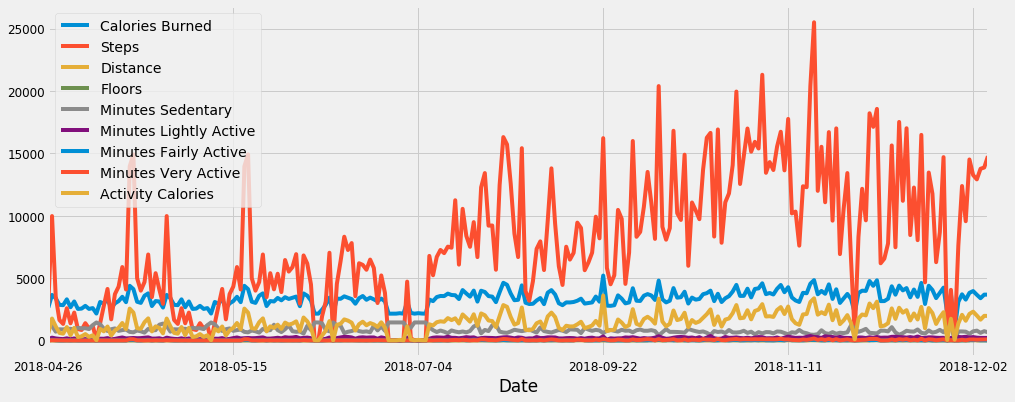

In [17]:
df2.plot(figsize=(15, 6))

Composition breakdown of the level, trend, seasonality and noise

In [21]:
y = df2['Minutes Sedentary']

In [26]:
result = sm.tsa.seasonal_decompose(y, model='additive')

AttributeError: 'Index' object has no attribute 'inferred_freq'

In [22]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

AttributeError: 'Index' object has no attribute 'inferred_freq'